In [1]:
from matplotlib import pyplot as plt
from superlet import superlet, scale_from_period
import mne 
from mne import create_info
import numpy as np
from burst_detection import extract_bursts
from fooof import FOOOF
from autoreject import AutoReject
import scipy.io

import pandas as pd
from matplotlib import ticker
from sklearn.decomposition import PCA
from sklearn.preprocessing import RobustScaler
import seaborn as sns

In [2]:
def many_is_in(multiple, target):
    check_ = []
    for i in multiple:
        check_.append(i in target)
    return any(check_)

In [3]:
SSD = scipy.io.loadmat('/Users/quentinmoreau/Documents/Work/schmidt_bursts/Data_Scripts_for_OSF/Dataset_1/Study5_BEH_data/S1_SSD_stop.mat')
SSD_data = SSD['num_align2']
df_SSD = pd.DataFrame(SSD_data, columns=['Trial', 'Time', 'Value'])  # Assign column names if known
# average value over all trials
SSD_val = df_SSD['Value'].mean()
SSD_val

131.97916666666666

In [ ]:
%%capture

data_path = '/Users/quentinmoreau/Documents/Work/schmidt_bursts/Data_Scripts_for_OSF/Dataset_1/Study5_EEG_data/'
electrodes = ['C3', 'F4'] # , 'C4', 'F3', 'FCz'
subject_ids =  ['S13', 'S14', 'S15']
#['S1', 'S2', 'S3', 'S5', 'S6', 'S7', 'S8', 'S10', 'S11',

bursts_all_results_laplac = []

for subject_id in subject_ids:
    subject_file = data_path + subject_id + '_stop_eeg_emg_ica_brain.set'
    print(f"Processing {subject_id}")
    raw  = mne.io.read_raw_eeglab(subject_file, eog='auto', preload=False, uint16_codec=None, verbose=None)
    raw.rename_channels({'FP1':'Fp1', 'FP2':'Fp2'})

    SSD = scipy.io.loadmat(f'/Users/quentinmoreau/Documents/Work/schmidt_bursts/Data_Scripts_for_OSF/Dataset_1/Study5_BEH_data/{subject_id}_SSD_stop.mat')
    SSD_data = SSD['num_align2']
    df_SSD = pd.DataFrame(SSD_data, columns=['Trial', 'Time', 'Value'])  # Assign column names if known
    # average value over all trials
    SSD_val = df_SSD['Value'].mean()

    builtin_montages = mne.channels.get_builtin_montages(descriptions=True)
    montage = mne.channels.make_standard_montage("easycap-M1")
    raw.set_montage(montage, verbose=False)
    events, event_id = mne.events_from_annotations(raw)
    # shift 'L_cueCG' and 'R_cueCG' events by SSD value
    events_shift = events.copy()
    for i in range(len(events)):
        if events_shift[i][2] == 1 or events_shift[i][2] == 9:
            events_shift[i][0] = events_shift[i][0] + SSD_val

    epochs = mne.Epochs(raw, events=events, picks = 'eeg', event_id = event_id, tmin=-1, tmax=2, baseline = (-.2, 0), event_repeated='merge', preload = True)
    epochs = mne.preprocessing.compute_current_source_density(epochs)

    frequencies = np.arange(1, 40, 1) 
    n_cycles = frequencies / 2  

    # compute time-frequency analysis

    SS = epochs['L_stopsigSS', 'R_stopsigSS']
    FS = epochs['L_stopsigFS', 'R_stopsigFS']
    GO = epochs['L_cueCG', 'R_cueCG']

    # Compute time-frequency analysis for SS condition
    SS_tfr = mne.time_frequency.tfr_morlet(SS, freqs=frequencies, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=1, n_jobs=1, verbose=None)

    # Compute time-frequency analysis for FS condition
    FS_tfr = mne.time_frequency.tfr_morlet(FS, freqs=frequencies, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=1, n_jobs=1, verbose=None)

    # Compute time-frequency analysis for GO condition
    GO_tfr = mne.time_frequency.tfr_morlet(GO, freqs=frequencies, n_cycles=n_cycles, use_fft=True, return_itc=False, decim=1, n_jobs=1, verbose=None)

    # save the subject's tfr
    file_path ='/Users/quentinmoreau/Documents/Work/schmidt_bursts/bursts_exp1/TFs/'
    SS_tfr_saving_name = file_path + subject_id + '_SS_tfr.h5'
    mne.time_frequency.write_tfrs(SS_tfr_saving_name, SS_tfr, overwrite=True)
    
    FS_tfr_saving_name = file_path + subject_id + '_FS_tfr.h5'
    mne.time_frequency.write_tfrs(FS_tfr_saving_name, FS_tfr, overwrite=True)

    GO_tfr_saving_name = file_path + subject_id + '_GO_tfr.h5'
    mne.time_frequency.write_tfrs(GO_tfr_saving_name, GO_tfr, overwrite=True)

    conditions = {'SS': SS, 'FS': FS, 'GO': GO}

    for condition_name, condition in conditions.items():
        for electrode in electrodes:
            times = condition.times
            ch_idx = condition.ch_names.index(electrode)
            trials = condition.get_data()[:, ch_idx, :]

            sfreq = condition.info['sfreq']
            max_freq = 120
            foi = np.linspace(1, max_freq, 120)
            scales = scale_from_period(1/foi)
            tf_trials = []

            for trial in trials:
                tf = superlet(
                    trial, sfreq, scales, 40, c_1=4, adaptive=True
                )
                tf_trials.append(np.single(np.abs(tf)))
            tf_trials = np.array(tf_trials)

            average_psd = np.average(tf_trials, axis=(2, 0))

            ff = FOOOF()
            ff.fit(foi, average_psd, [1, 120])
            ap = 10 ** ff._ap_fit 

            search_range = np.where((foi >= 10) & (foi <= 33))[0]
            beta_lims = [13, 30]

            bursts = extract_bursts(
                trials, tf_trials[:,search_range], times, 
                foi[search_range], beta_lims, 
                ap[search_range].reshape(-1, 1), sfreq
            )
            experiment  = 'Exp1'
            epochs = 'Stop'
            bursts['condition'] = np.tile(condition_name, bursts['trial'].shape)
            bursts['electrode'] = np.tile(electrode, bursts['trial'].shape)
            bursts['subject'] = np.tile(subject_id, bursts['trial'].shape)
            bursts['experiment'] = np.tile(experiment, bursts['trial'].shape)
            bursts['epochs'] = np.tile(epochs, bursts['trial'].shape)

            bursts_all_results_laplac.append(bursts)

            # f, ax = plt.subplots(1, 1, figsize=(5, 5))
            # mean_waveform = np.mean(bursts["waveform"], axis=0)
            # ax.plot(bursts["waveform_times"], bursts["waveform"].T, lw=0.2);
            # ax.plot(bursts["waveform_times"], mean_waveform, lw=1, c="black");
            # ax.set_xlim(bursts["waveform_times"][0], bursts["waveform_times"][-1])
            # ax.set_title(f"{condition_name} - Electrode {electrode}")

            waveform_times = bursts_all_results_laplac[0]["waveform_times"]

path = '/Users/quentinmoreau/Documents/Work/schmidt_bursts/bursts_exp1'
# save bursts_all_results as npy
np.save(f'{path}/bursts_all_results_laplac.npy', bursts_all_results_laplac)

# save waveform_times
np.save(f'{path}/waveform_times.npy', waveform_times)


In [5]:
path = '/Users/quentinmoreau/Documents/Work/schmidt_bursts/bursts_exp1'
waveform_times = np.load(f'{path}/waveform_times.npy')
bursts_all_results_laplac = np.load(f'{path}/bursts_all_results_laplac.npy', allow_pickle=True)

In [21]:
bursts_all_results_laplac[0].keys()

dict_keys(['trial', 'waveform', 'peak_freq', 'peak_amp_iter', 'peak_amp_base', 'peak_time', 'peak_adjustment', 'fwhm_freq', 'fwhm_time', 'polarity', 'waveform_times', 'condition', 'electrode', 'subject', 'experiment', 'epochs'])

/var/folders/6s/2qfkp2515r7f660tnsjg8t440000gq/T/ipykernel_39685/3424990677.py:72: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


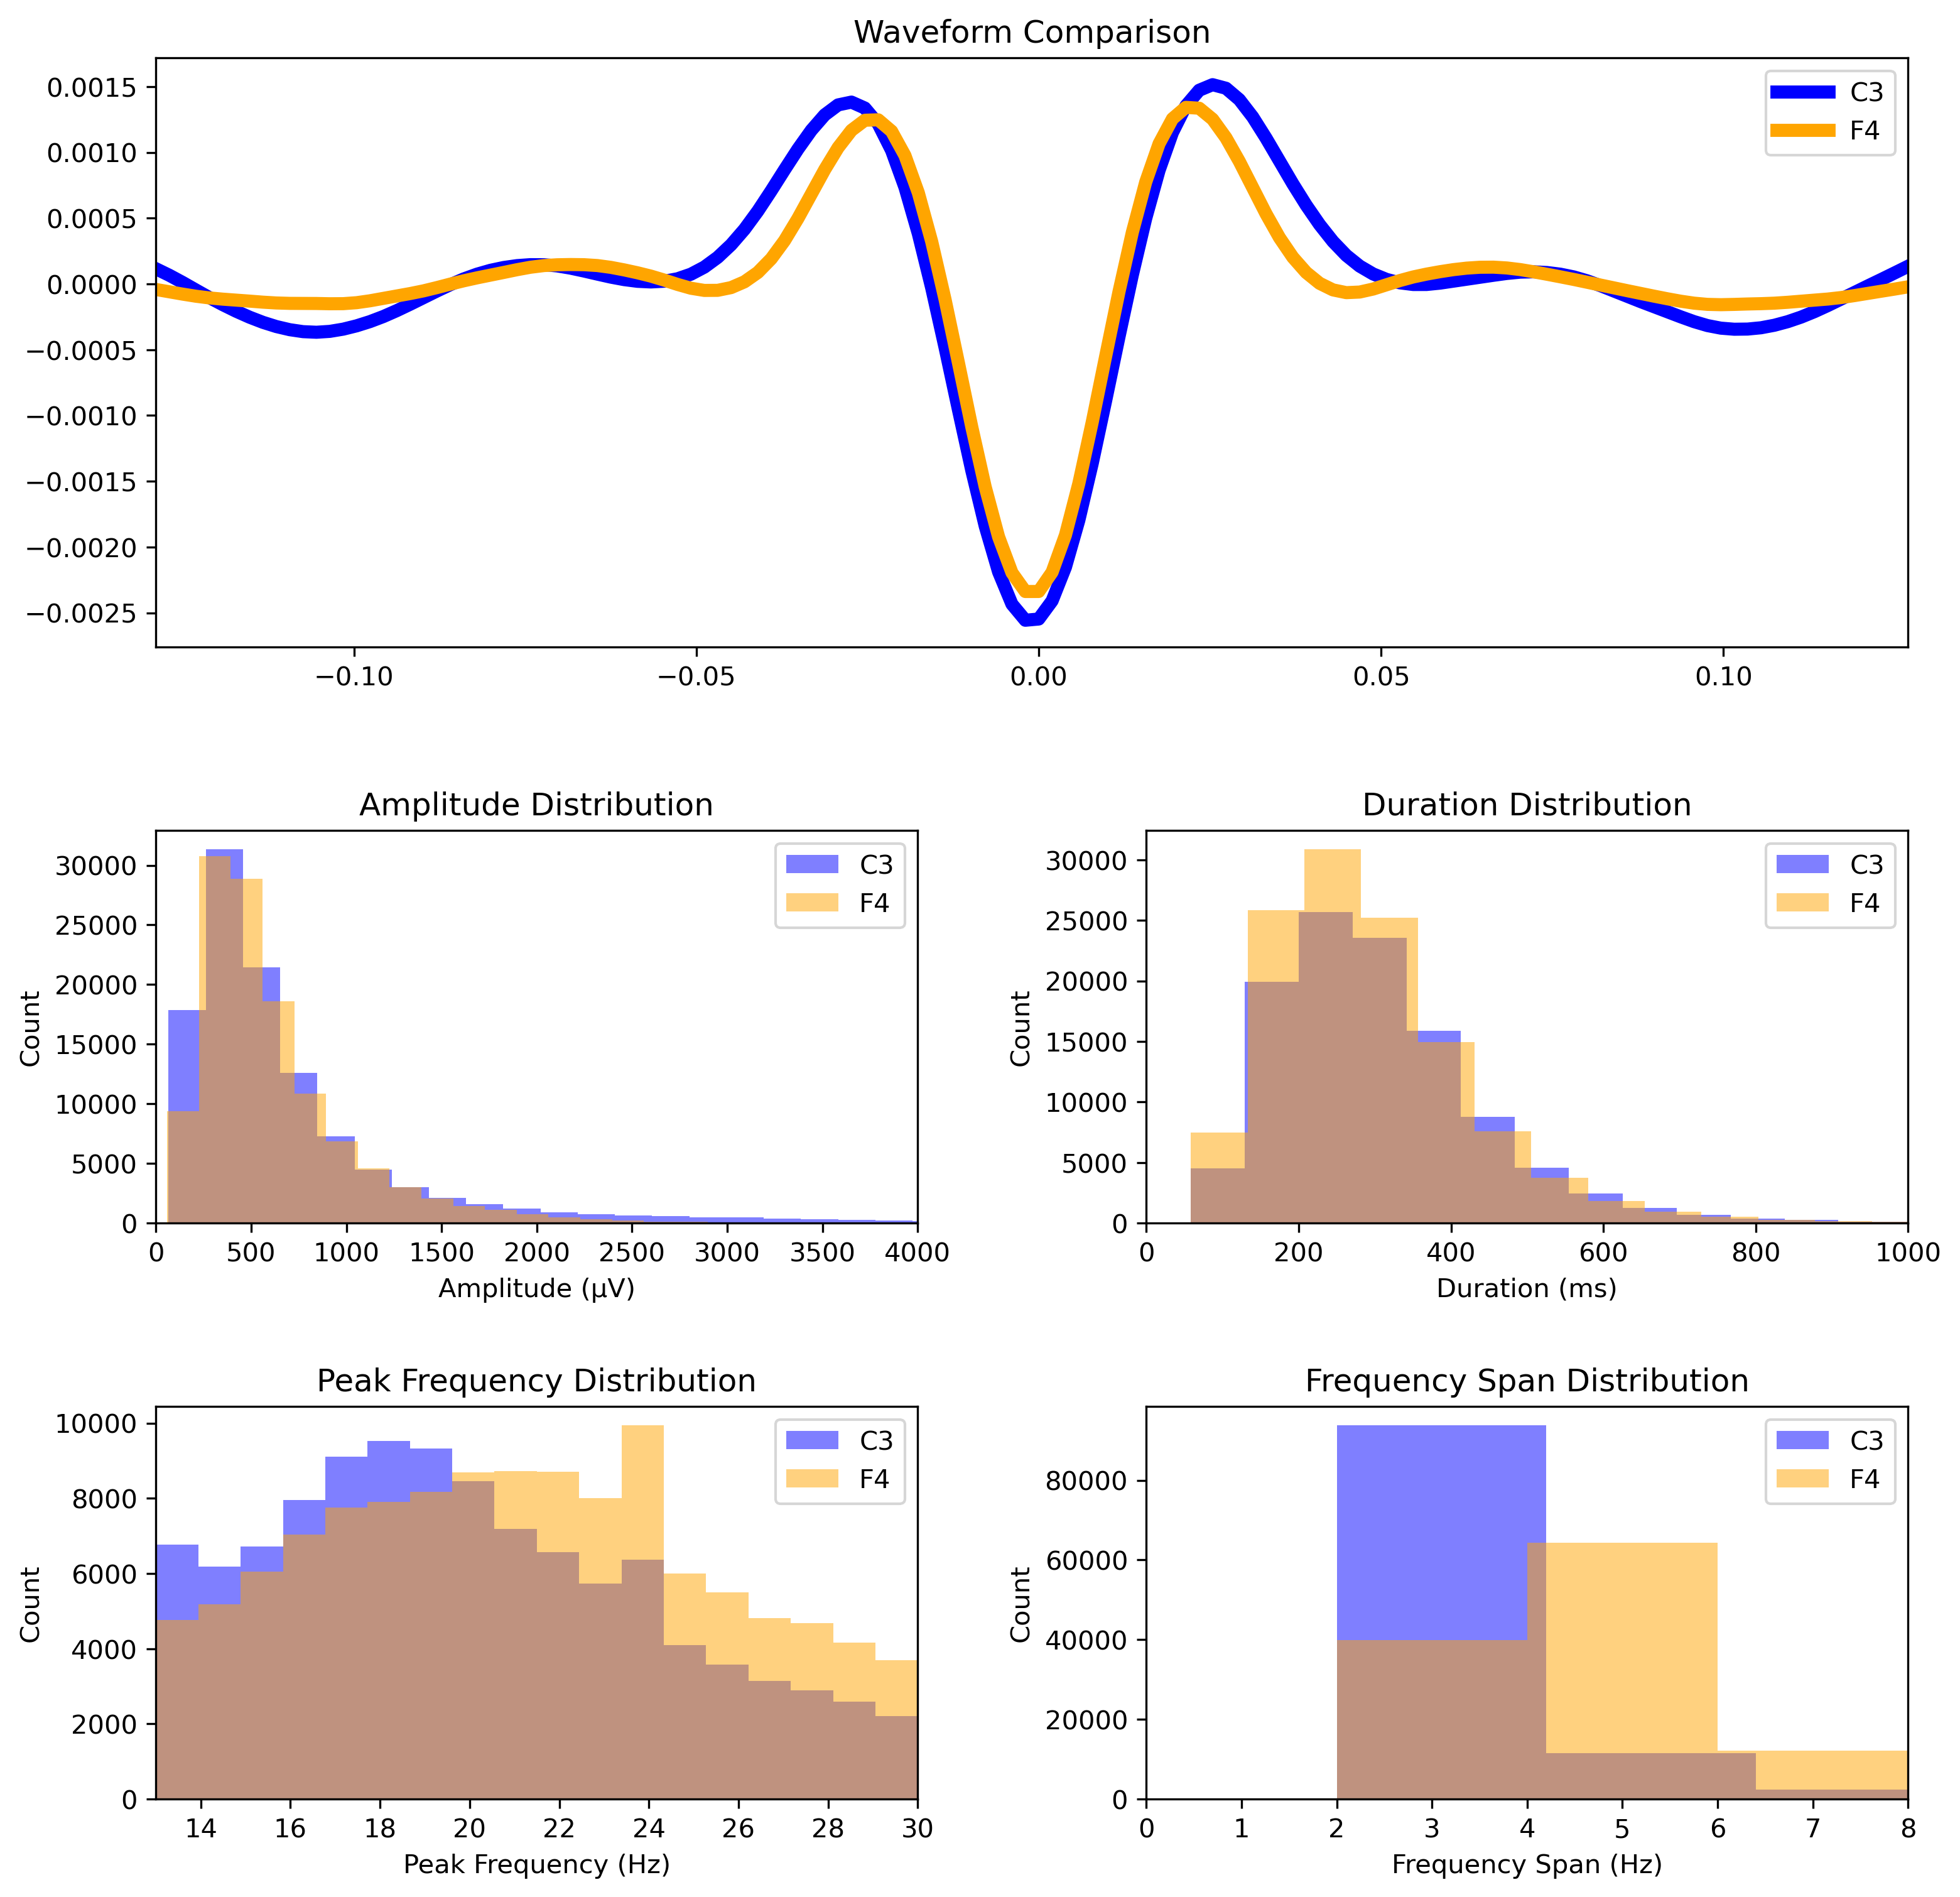

In [63]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Prepare the figure with GridSpec layout
fig = plt.figure(figsize=(12, 12), dpi=300)
gs = gridspec.GridSpec(3, 2, height_ratios=[1.5, 1, 1], hspace=0.4, wspace=0.3)

bursts_C3 = [burst for burst in bursts_all_results_laplac if burst['electrode'][0] == 'C3']
bursts_F4 = [burst for burst in bursts_all_results_laplac if burst['electrode'][0] == 'F4']

# Waveform comparison plot (spans the first row)
ax0 = fig.add_subplot(gs[0, :])  # Span all columns
waveforms_C3 = [burst["waveform"] for burst in bursts_C3]
waveforms_F4 = [burst["waveform"] for burst in bursts_F4]
mean_waveform_C3 = np.mean(np.concatenate(waveforms_C3, axis=0), axis=0)
mean_waveform_F4 = np.mean(np.concatenate(waveforms_F4, axis=0), axis=0)
ax0.plot(waveform_times, mean_waveform_C3, lw=5, c="blue", label='C3')
ax0.plot(waveform_times, mean_waveform_F4, lw=5, c="orange", label='F4')
ax0.set_title("Waveform Comparison")
ax0.set_xlim(waveform_times[0], waveform_times[-1])
ax0.legend()

# Amplitude distribution (top left of second row)
ax1 = fig.add_subplot(gs[1, 0])
amplitudes_C3 = np.concatenate([burst['peak_amp_base'] for burst in bursts_C3]) * 1e6  # Convert to µV
amplitudes_F4 = np.concatenate([burst['peak_amp_base'] for burst in bursts_F4]) * 1e6  # Convert to µV
ax1.hist(amplitudes_C3, bins=30, alpha=0.5, color="blue", label="C3")
ax1.hist(amplitudes_F4, bins=30, alpha=0.5, color="orange", label="F4")
ax1.set_title("Amplitude Distribution")
ax1.set_xlabel("Amplitude (µV)")
ax1.set_xlim(0, 4000)
ax1.set_ylabel("Count")
ax1.legend()

# Duration distribution (top right of second row)
ax2 = fig.add_subplot(gs[1, 1])
durations_C3 = np.concatenate([burst['fwhm_time'] for burst in bursts_C3]) * 1e3  # Convert to ms
durations_F4 = np.concatenate([burst['fwhm_time'] for burst in bursts_F4]) * 1e3  # Convert to ms
ax2.hist(durations_C3, bins=30, alpha=0.5, color="blue", label="C3")
ax2.hist(durations_F4, bins=30, alpha=0.5, color="orange", label="F4")
ax2.set_title("Duration Distribution")
ax2.set_xlabel("Duration (ms)")
ax2.set_xlim(0, 1000)
ax2.set_ylabel("Count")
ax2.legend()

# Peak frequency distribution (bottom left)
ax3 = fig.add_subplot(gs[2, 0])
peak_freq_C3 = np.concatenate([burst['peak_freq'] for burst in bursts_C3])
peak_freq_F4 = np.concatenate([burst['peak_freq'] for burst in bursts_F4])
ax3.hist(peak_freq_C3, bins=18, alpha=0.5, color="blue", label="C3")
ax3.hist(peak_freq_F4, bins=18, alpha=0.5, color="orange", label="F4")
ax3.set_title("Peak Frequency Distribution")
ax3.set_xlabel("Peak Frequency (Hz)")
ax3.set_ylabel("Count")
ax3.set_xlim(13, 30)
ax3.legend()

# Frequency span distribution (bottom right)
ax4 = fig.add_subplot(gs[2, 1])
freq_span_C3 = np.concatenate([burst['fwhm_freq'] for burst in bursts_C3])
freq_span_F4 = np.concatenate([burst['fwhm_freq'] for burst in bursts_F4])
ax4.hist(freq_span_C3, bins=10, alpha=0.5, color="blue", label="C3")
ax4.hist(freq_span_F4, bins=10, alpha=0.5, color="orange", label="F4")
ax4.set_title("Frequency Span Distribution")
ax4.set_xlim(0, 8)
ax4.set_xlabel("Frequency Span (Hz)")
ax4.set_ylabel("Count")
ax4.legend()

plt.tight_layout()
plt.show()


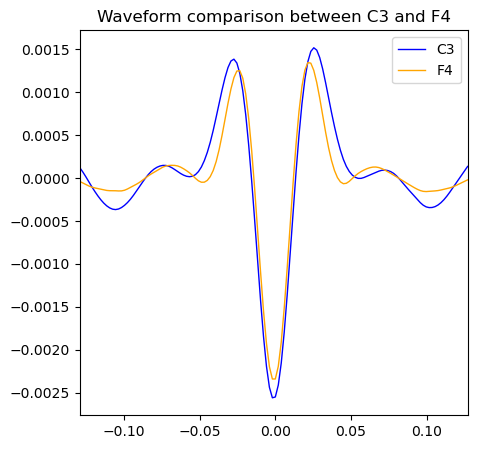

In [32]:
# Initialize lists to collect waveforms for C3 and F4
waveforms_C3 = []
waveforms_F4 = []

# Aggregate waveforms for each electrode across all subjects and conditions
for bursts in bursts_all_results_laplac:
    if bursts['electrode'][0] == 'C3':  # Check electrode name
        waveforms_C3.append(bursts["waveform"])
    elif bursts['electrode'][0] == 'F4':  # Check electrode name
        waveforms_F4.append(bursts["waveform"])

# Combine collected waveforms and compute mean
mean_waveform_C3 = np.mean(np.concatenate(waveforms_C3, axis=0), axis=0)
mean_waveform_F4 = np.mean(np.concatenate(waveforms_F4, axis=0), axis=0)

# Plot the results
f, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(waveform_times, mean_waveform_C3, lw=1, c="blue", label='C3')
ax.plot(waveform_times, mean_waveform_F4, lw=1, c="orange", label='F4')
ax.set_xlim(waveform_times[0], waveform_times[-1])
ax.set_title(f"Waveform comparison between C3 and F4")
ax.legend()
plt.show()


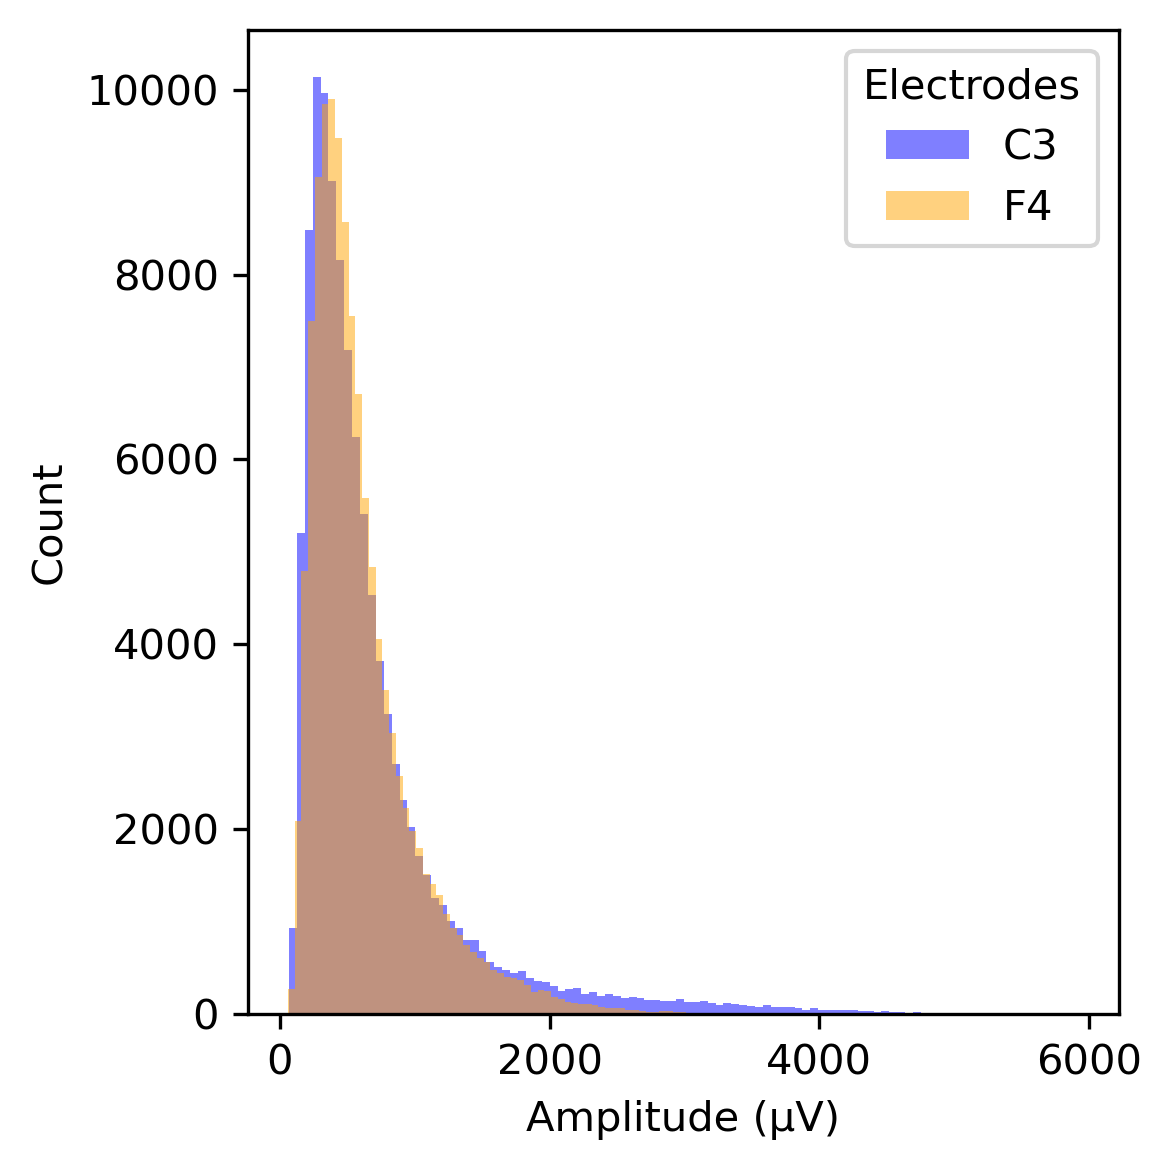

In [ ]:
# Filter bursts for C3 and F4
bursts_C3 = [burst for burst in bursts_all_results_laplac if burst['electrode'][0] == 'C3']
bursts_F4 = [burst for burst in bursts_all_results_laplac if burst['electrode'][0] == 'F4']

# Extract amplitude values (peak_amp_base)
amplitudes_C3 = np.concatenate([burst['peak_amp_base'] for burst in bursts_C3])
amplitudes_F4 = np.concatenate([burst['peak_amp_base'] for burst in bursts_F4])

# Convert to µV
amplitudes_C3_conv = amplitudes_C3 * 1e6
amplitudes_F4_conv = amplitudes_F4 * 1e6

# Plot histograms
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

# Histogram for C3
ax.hist(amplitudes_C3_conv, bins=100, alpha=0.5, color="blue", label="C3")

# Histogram for F4
ax.hist(amplitudes_F4_conv, bins=100, alpha=0.5, color="orange", label="F4")

# Customize plot
ax.legend(title="Electrodes")
ax.set_ylabel("Count")
ax.set_xlabel("Amplitude (µV)")
plt.tight_layout()
plt.show()


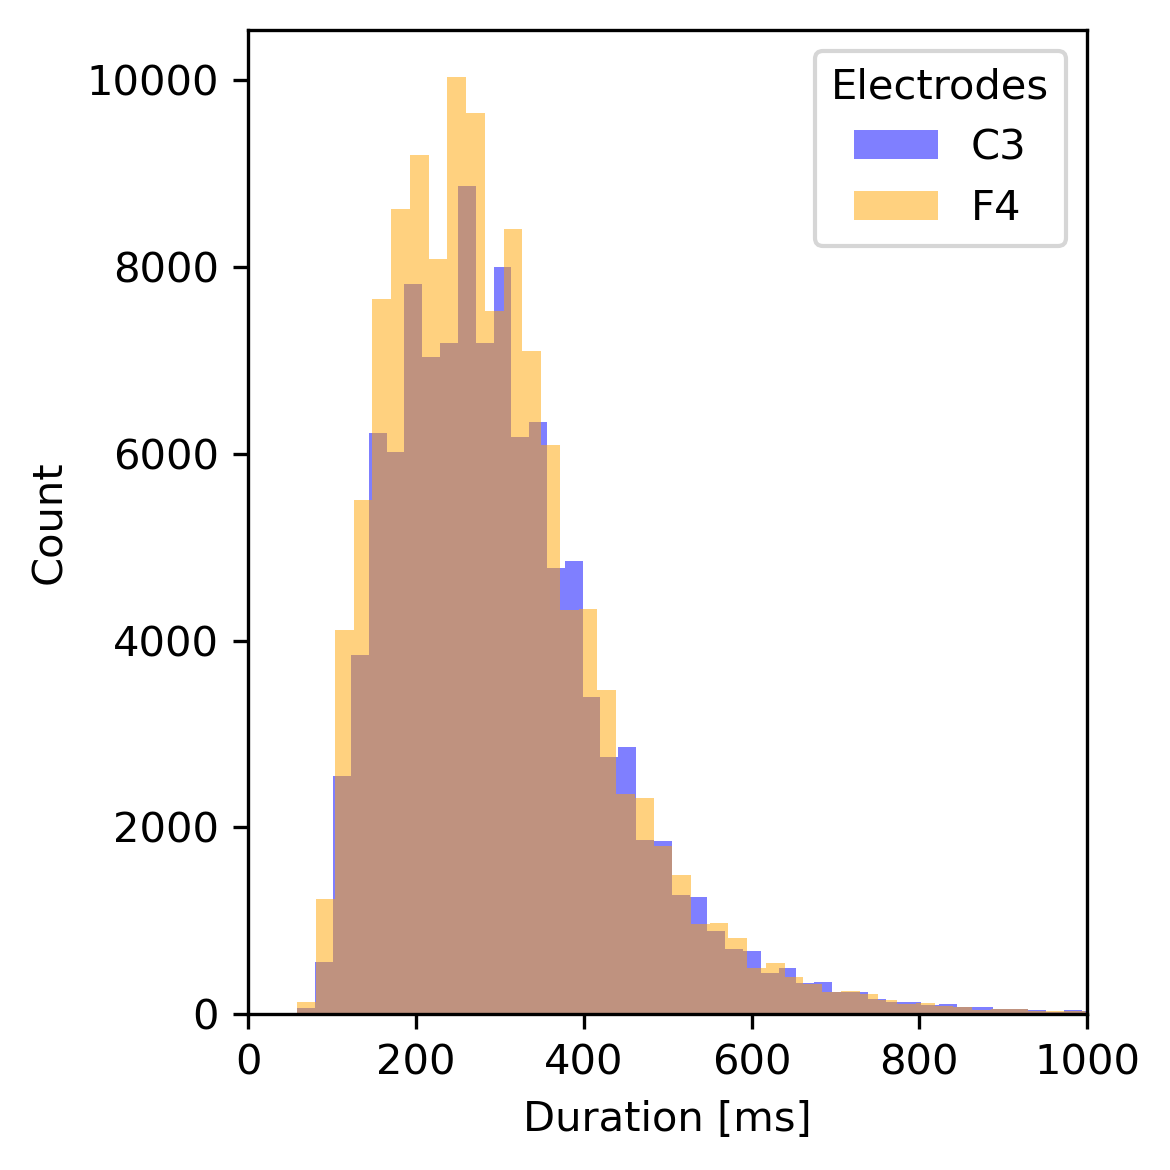

In [34]:
# Filter bursts for C3 and F4
bursts_C3 = [burst for burst in bursts_all_results_laplac if burst['electrode'][0] == 'C3']
bursts_F4 = [burst for burst in bursts_all_results_laplac if burst['electrode'][0] == 'F4']

# Extract duration values (fwhm_time) and convert to milliseconds
durations_C3 = np.concatenate([burst['fwhm_time'] for burst in bursts_C3]) * 1e3  # Convert to ms
durations_F4 = np.concatenate([burst['fwhm_time'] for burst in bursts_F4]) * 1e3  # Convert to ms

# Plot histograms
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

# Histogram for C3
ax.hist(durations_C3, bins=100, alpha=0.5, color="blue", label="C3")

# Histogram for F4
ax.hist(durations_F4, bins=100, alpha=0.5, color="orange", label="F4")

# Customize plot
ax.set_xlim(0, 1000)  # Adjust based on duration range
ax.legend(title="Electrodes")
ax.set_ylabel("Count")
ax.set_xlabel("Duration [ms]")
plt.tight_layout()
plt.show()


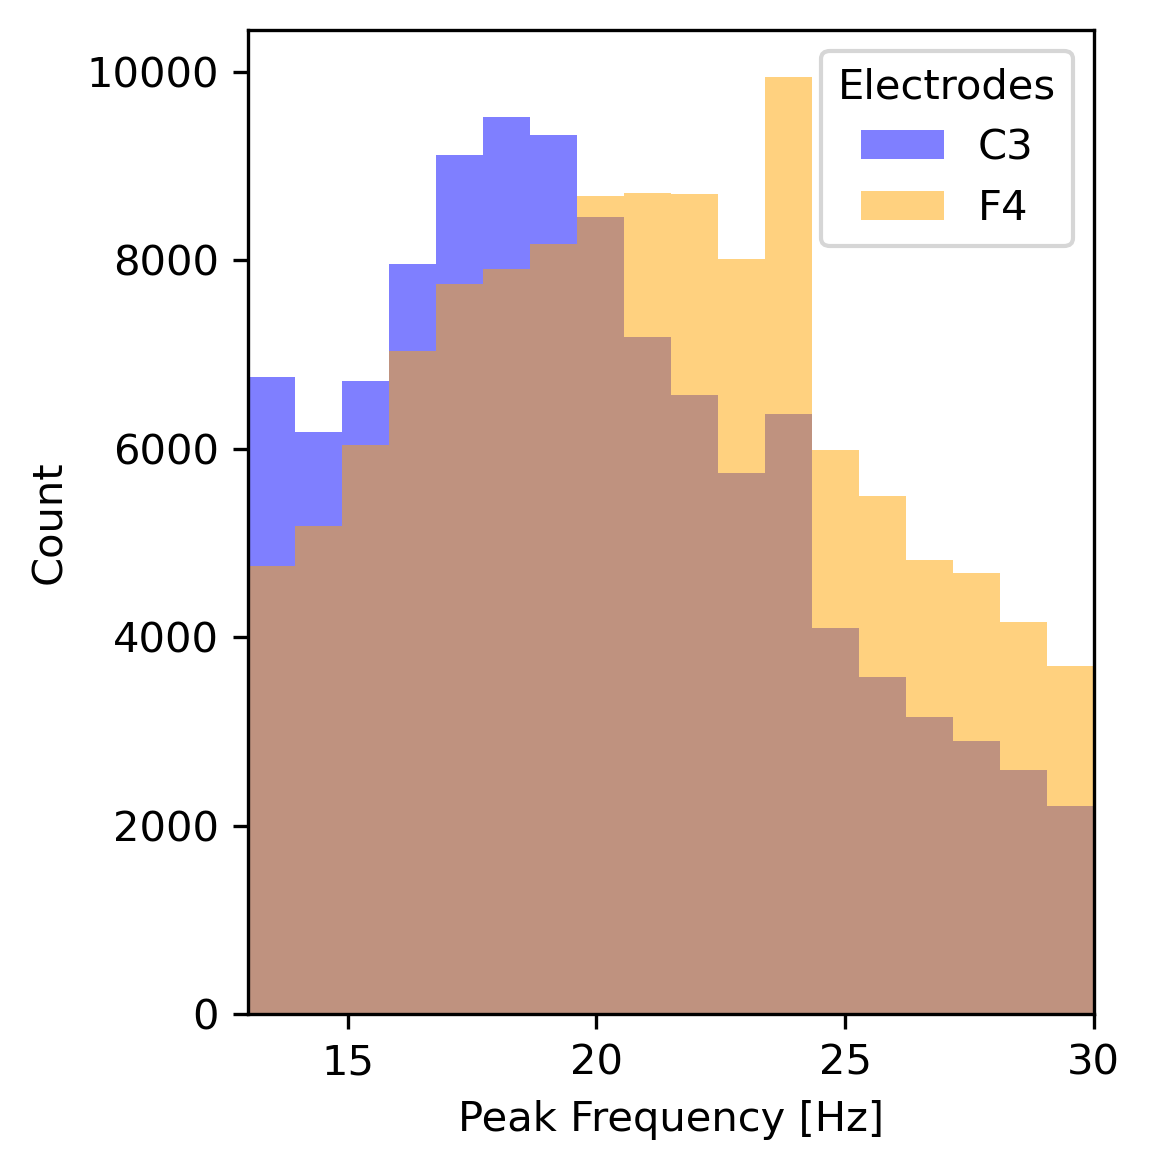

In [41]:
# Filter bursts for C3 and F4
bursts_C3 = [burst for burst in bursts_all_results_laplac if burst['electrode'][0] == 'C3']
bursts_F4 = [burst for burst in bursts_all_results_laplac if burst['electrode'][0] == 'F4']

# Extract peak frequency values (peak_freq)
peak_freq_C3 = np.concatenate([burst['peak_freq'] for burst in bursts_C3])
peak_freq_F4 = np.concatenate([burst['peak_freq'] for burst in bursts_F4])

# Plot histograms
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

# Histogram for C3
ax.hist(peak_freq_C3, bins=18, alpha=0.5, color="blue", label="C3")

# Histogram for F4
ax.hist(peak_freq_F4, bins=18, alpha=0.5, color="orange", label="F4")

# Customize plot
ax.set_xlim(13, 30)  # Adjust based on your frequency range of interest
ax.legend(title="Electrodes")
ax.set_ylabel("Count")
ax.set_xlabel("Peak Frequency [Hz]")
plt.tight_layout()
plt.show()


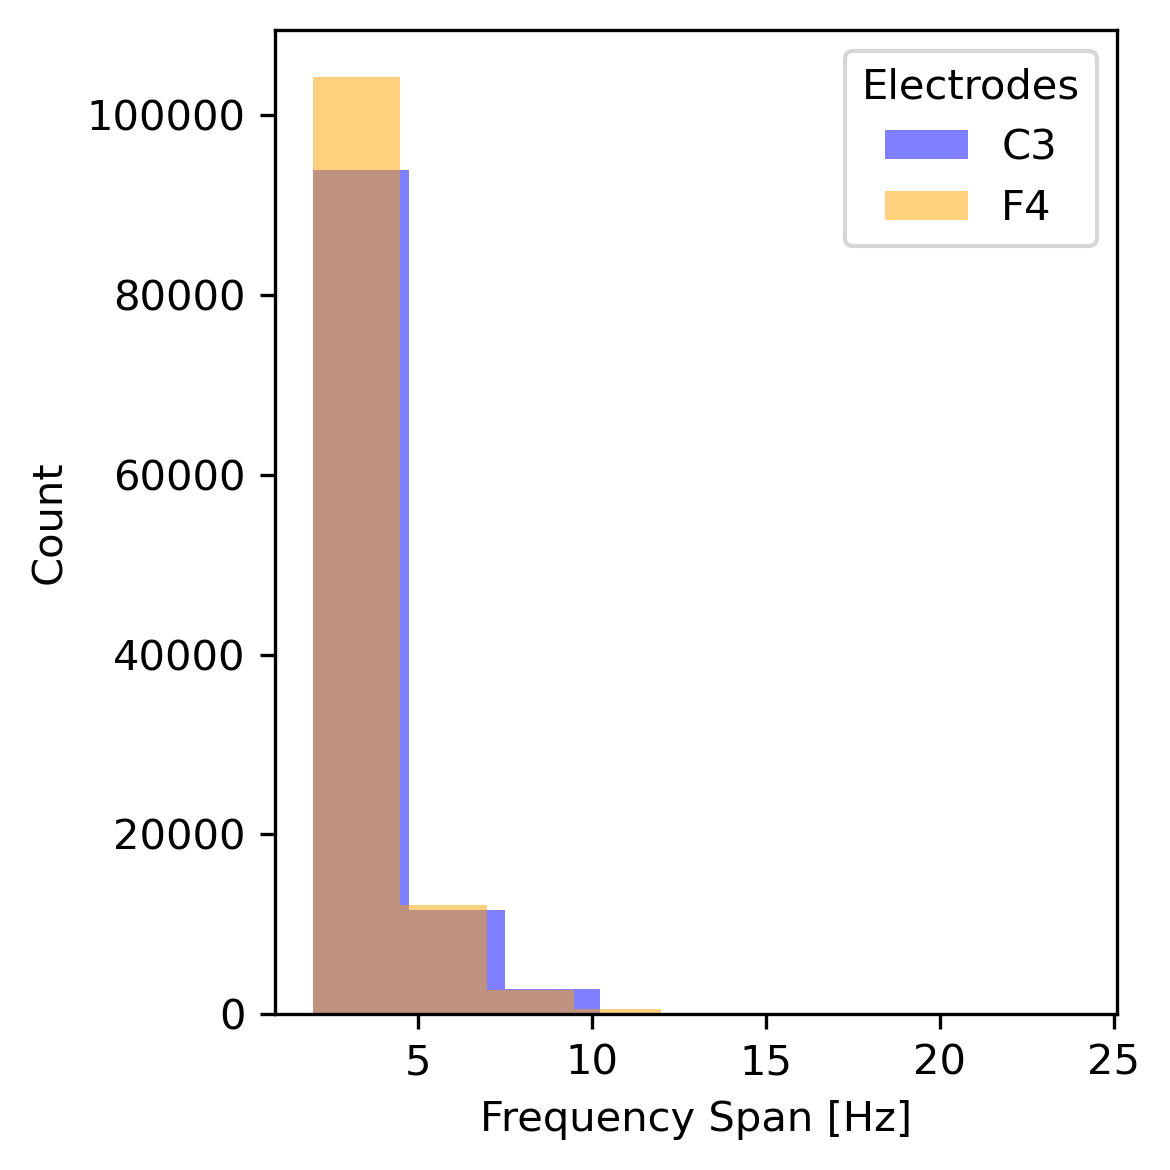

In [52]:
# Filter bursts for C3 and F4
bursts_C3 = [burst for burst in bursts_all_results_laplac if burst['electrode'][0] == 'C3']
bursts_F4 = [burst for burst in bursts_all_results_laplac if burst['electrode'][0] == 'F4']

# Extract frequency span values (fwhm_freq)
freq_span_C3 = np.concatenate([burst['fwhm_freq'] for burst in bursts_C3])
freq_span_F4 = np.concatenate([burst['fwhm_freq'] for burst in bursts_F4])

# Plot histograms
f, ax = plt.subplots(1, 1, figsize=(4, 4), dpi=300)

# Histogram for C3
ax.hist(freq_span_C3, bins=8, alpha=0.5, color="blue", label="C3")

# Histogram for F4
ax.hist(freq_span_F4, bins=8, alpha=0.5, color="orange", label="F4")

# Customize plot
ax.legend(title="Electrodes")
ax.set_ylabel("Count")
ax.set_xlabel("Frequency Span [Hz]")
plt.tight_layout()
plt.show()


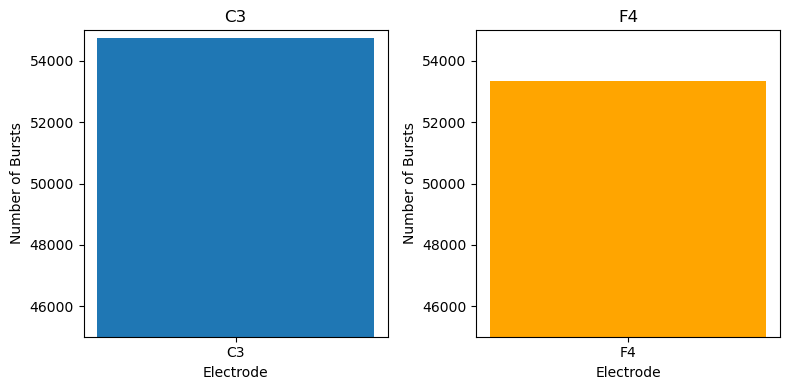

In [ ]:
# # Count the number of bursts for C3 and F4
# num_bursts_c3 = features_scores[features_scores['electrode'] == 'C3'].shape[0]
# num_bursts_f4 = features_scores[features_scores['electrode'] == 'F4'].shape[0]

# # Create bar plots for C3 and F4
# fig, ax = plt.subplots(1, 2, figsize=(8, 4))

# # Bar plot for C3
# ax[0].bar('C3', num_bursts_c3)
# ax[0].set_xlabel('Electrode')
# ax[0].set_ylabel('Number of Bursts')
# ax[0].set_title('C3')
# ax[0].set_ylim([45000, 55000])

# # Bar plot for F4
# ax[1].bar('F4', num_bursts_f4, color='orange')
# ax[1].set_xlabel('Electrode')
# ax[1].set_ylabel('Number of Bursts')
# ax[1].set_title('F4')
# ax[1].set_ylim([45000, 55000])


# plt.tight_layout()
# plt.show()


In [25]:
time_bin = 0.05
time_buffer = 0.125
burst_rates_exp1_SS_C3_cue = calculate_burst_rates(features_scores, exp='Exp1', condition='SS', electrode = 'C3', epoch='Cue', time_bin=time_bin, time_buffer=time_buffer)
burst_rates_exp1_FS_C3_cue = calculate_burst_rates(features_scores, exp='Exp1', condition='FS', electrode = 'C3', epoch='Cue', time_bin=time_bin, time_buffer=time_buffer)

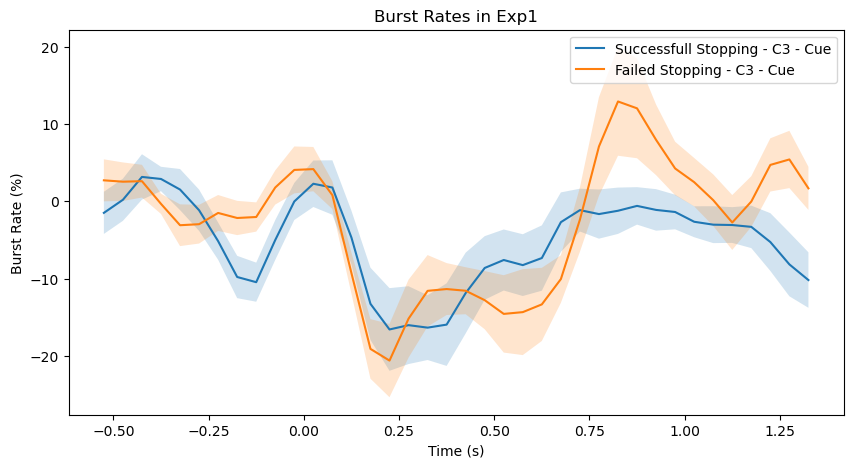

In [ ]:
# # Plot Cue Burst Rates for C3
# # calculate mean and standard error
# mean_burst_rates_exp1_SS_C3_cue = np.mean(burst_rates_exp1_SS_C3_cue, axis=0)
# std_err_burst_rates_exp1_SS_C3_cue = np.std(burst_rates_exp1_SS_C3_cue, axis=0) / np.sqrt(len(burst_rates_exp1_SS_C3_cue))

# mean_burst_rates_exp1_FS_C3_cue = np.mean(burst_rates_exp1_FS_C3_cue, axis=0)
# std_err_burst_rates_exp1_FS_C3_cue = np.std(burst_rates_exp1_FS_C3_cue, axis=0) / np.sqrt(len(burst_rates_exp1_FS_C3_cue))

# # plot mean burst rates
# f, ax = plt.subplots(1, 1, figsize=(10, 5))
# time_range = np.arange(-1 - 0.125, 2 + 0.125, 0.05)
# ax.plot(time_range[12:50], mean_burst_rates_exp1_SS_C3_cue[12:50], label='Successfull Stopping - C3 - Cue')
# ax.fill_between(time_range[12:50], mean_burst_rates_exp1_SS_C3_cue[12:50] - std_err_burst_rates_exp1_SS_C3_cue[12:50], mean_burst_rates_exp1_SS_C3_cue[12:50] + std_err_burst_rates_exp1_SS_C3_cue[12:50], alpha=0.2)

# ax.plot(time_range[12:50], mean_burst_rates_exp1_FS_C3_cue[12:50], label='Failed Stopping - C3 - Cue')
# ax.fill_between(time_range[12:50], mean_burst_rates_exp1_FS_C3_cue[12:50] - std_err_burst_rates_exp1_FS_C3_cue[12:50], mean_burst_rates_exp1_FS_C3_cue[12:50] + std_err_burst_rates_exp1_FS_C3_cue[12:50], alpha=0.2)

# ax.set_title('Burst Rates in Exp1')
# ax.set_ylabel('Burst Rate (%)')
# ax.set_xlabel('Time (s)')
# ax.legend()
# plt.show()


In [ ]:
# time_bin = 0.05
# time_buffer = 0.125
# burst_rates_exp1_SS_C3_stop = calculate_burst_rates(features_scores, exp='Exp1', condition='SS', electrode = 'C3', epoch='Stop', time_bin=time_bin, time_buffer=time_buffer)
# burst_rates_exp1_FS_C3_stop = calculate_burst_rates(features_scores, exp='Exp1', condition='FS', electrode = 'C3', epoch='Stop', time_bin=time_bin, time_buffer=time_buffer)

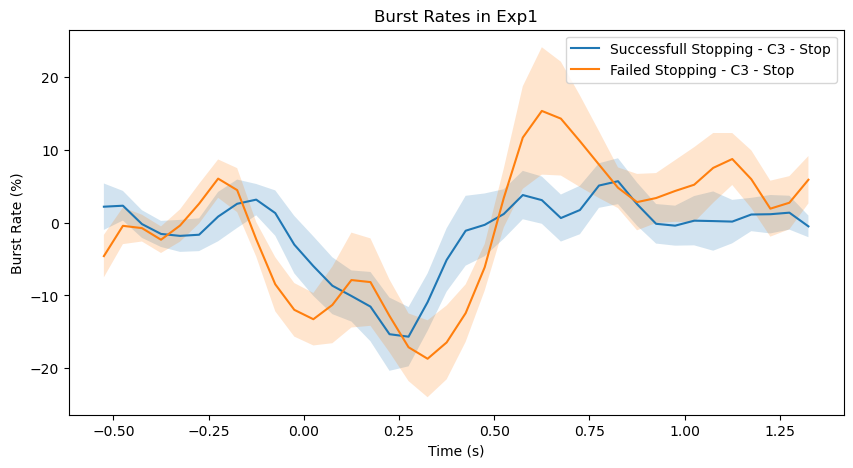

In [ ]:
# # Plot Stop Burst Rates for C3
# # calculate mean and standard error
# mean_burst_rates_exp1_SS_C3_stop = np.mean(burst_rates_exp1_SS_C3_stop, axis=0)
# std_err_burst_rates_exp1_SS_C3_stop = np.std(burst_rates_exp1_SS_C3_stop, axis=0) / np.sqrt(len(burst_rates_exp1_SS_C3_stop))

# mean_burst_rates_exp1_FS_C3_stop = np.mean(burst_rates_exp1_FS_C3_stop, axis=0)
# std_err_burst_rates_exp1_FS_C3_stop = np.std(burst_rates_exp1_FS_C3_stop, axis=0) / np.sqrt(len(burst_rates_exp1_FS_C3_stop))

# # plot mean burst rates
# f, ax = plt.subplots(1, 1, figsize=(10, 5))
# time_range = np.arange(-1 - 0.125, 2 + 0.125, 0.05)
# ax.plot(time_range[12:50], mean_burst_rates_exp1_SS_C3_stop[12:50], label='Successfull Stopping - C3 - Stop')
# ax.fill_between(time_range[12:50], mean_burst_rates_exp1_SS_C3_stop[12:50] - std_err_burst_rates_exp1_SS_C3_stop[12:50], mean_burst_rates_exp1_SS_C3_stop[12:50] + std_err_burst_rates_exp1_SS_C3_stop[12:50], alpha=0.2)

# ax.plot(time_range[12:50], mean_burst_rates_exp1_FS_C3_stop[12:50], label='Failed Stopping - C3 - Stop')
# ax.fill_between(time_range[12:50], mean_burst_rates_exp1_FS_C3_stop[12:50] - std_err_burst_rates_exp1_FS_C3_stop[12:50], mean_burst_rates_exp1_FS_C3_stop[12:50] + std_err_burst_rates_exp1_FS_C3_stop[12:50], alpha=0.2)

# ax.set_title('Burst Rates in Exp1')
# ax.set_ylabel('Burst Rate (%)')
# ax.set_xlabel('Time (s)')
# ax.legend()

In [ ]:
# time_bin = 0.05
# time_buffer = 0.125
# burst_rates_exp1_SS_F4_cue = calculate_burst_rates(features_scores, exp='Exp1', condition='SS', electrode = 'F4', epoch='Cue', time_bin=time_bin, time_buffer=time_buffer)
# burst_rates_exp1_FS_F4_cue = calculate_burst_rates(features_scores, exp='Exp1', condition='FS', electrode = 'F4', epoch='Cue', time_bin=time_bin, time_buffer=time_buffer)

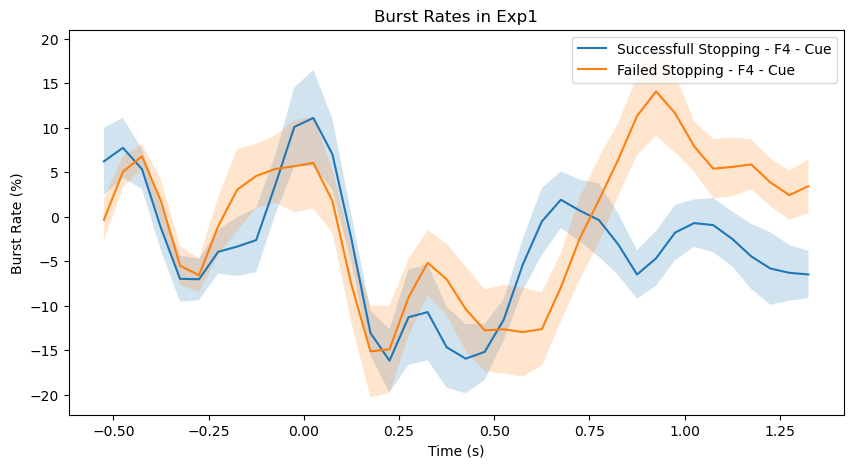

In [ ]:
# # Plot Cue Burst Rates for F4
# # calculate mean and standard error
# mean_burst_rates_exp1_SS_F4_cue = np.mean(burst_rates_exp1_SS_F4_cue, axis=0)
# std_err_burst_rates_exp1_SS_F4_cue = np.std(burst_rates_exp1_SS_F4_cue, axis=0) / np.sqrt(len(burst_rates_exp1_SS_F4_cue))

# mean_burst_rates_exp1_FS_F4_cue = np.mean(burst_rates_exp1_FS_F4_cue, axis=0)
# std_err_burst_rates_exp1_FS_F4_cue = np.std(burst_rates_exp1_FS_F4_cue, axis=0) / np.sqrt(len(burst_rates_exp1_FS_F4_cue))

# # plot mean burst rates
# f, ax = plt.subplots(1, 1, figsize=(10, 5))
# time_range = np.arange(-1 - 0.125, 2 + 0.125, 0.05)
# ax.plot(time_range[12:50], mean_burst_rates_exp1_SS_F4_cue[12:50], label='Successfull Stopping - F4 - Cue')
# ax.fill_between(time_range[12:50], mean_burst_rates_exp1_SS_F4_cue[12:50] - std_err_burst_rates_exp1_SS_F4_cue[12:50], mean_burst_rates_exp1_SS_F4_cue[12:50] + std_err_burst_rates_exp1_SS_F4_cue[12:50], alpha=0.2)

# ax.plot(time_range[12:50], mean_burst_rates_exp1_FS_F4_cue[12:50], label='Failed Stopping - F4 - Cue')
# ax.fill_between(time_range[12:50], mean_burst_rates_exp1_FS_F4_cue[12:50] - std_err_burst_rates_exp1_FS_F4_cue[12:50], mean_burst_rates_exp1_FS_F4_cue[12:50] + std_err_burst_rates_exp1_FS_F4_cue[12:50], alpha=0.2)

# ax.set_title('Burst Rates in Exp1')
# ax.set_ylabel('Burst Rate (%)')
# ax.set_xlabel('Time (s)')
# ax.legend()
# plt.show()



In [ ]:
# time_bin = 0.05
# time_buffer = 0.125
# burst_rates_exp1_SS_F4_stop = calculate_burst_rates(features_scores, exp='Exp1', condition='SS', electrode = 'F4', epoch='Stop', time_bin=time_bin, time_buffer=time_buffer)
# burst_rates_exp1_FS_F4_stop = calculate_burst_rates(features_scores, exp='Exp1', condition='FS', electrode = 'F4', epoch='Stop', time_bin=time_bin, time_buffer=time_buffer)

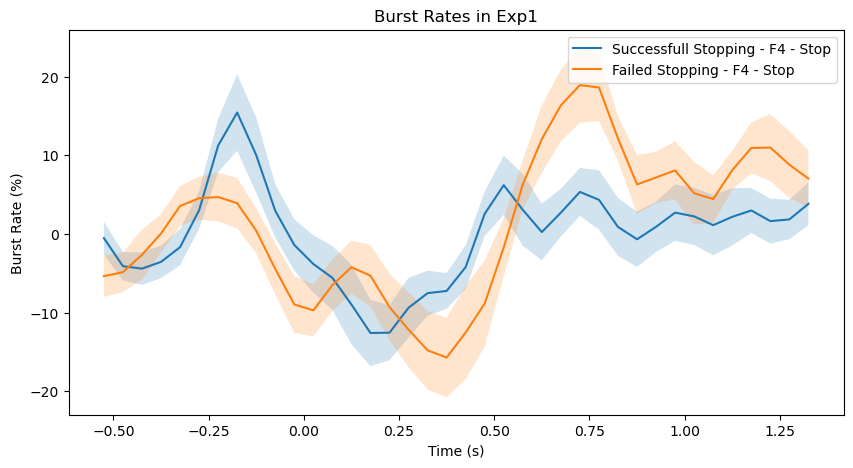

In [ ]:
# # Plot Stop Burst Rates for F4
# # calculate mean and standard error
# mean_burst_rates_exp1_SS_F4_stop = np.mean(burst_rates_exp1_SS_F4_stop, axis=0)
# std_err_burst_rates_exp1_SS_F4_stop = np.std(burst_rates_exp1_SS_F4_stop, axis=0) / np.sqrt(len(burst_rates_exp1_SS_F4_stop))

# mean_burst_rates_exp1_FS_F4_stop = np.mean(burst_rates_exp1_FS_F4_stop, axis=0)
# std_err_burst_rates_exp1_FS_F4_stop = np.std(burst_rates_exp1_FS_F4_stop, axis=0) / np.sqrt(len(burst_rates_exp1_FS_F4_stop))

# # plot mean burst rates
# f, ax = plt.subplots(1, 1, figsize=(10, 5))
# time_range = np.arange(-1 - 0.125, 2 + 0.125, 0.05)
# ax.plot(time_range[12:50], mean_burst_rates_exp1_SS_F4_stop[12:50], label='Successfull Stopping - F4 - Stop')
# ax.fill_between(time_range[12:50], mean_burst_rates_exp1_SS_F4_stop[12:50] - std_err_burst_rates_exp1_SS_F4_stop[12:50], mean_burst_rates_exp1_SS_F4_stop[12:50] + std_err_burst_rates_exp1_SS_F4_stop[12:50], alpha=0.2)

# ax.plot(time_range[12:50], mean_burst_rates_exp1_FS_F4_stop[12:50], label='Failed Stopping - F4 - Stop')
# ax.fill_between(time_range[12:50], mean_burst_rates_exp1_FS_F4_stop[12:50] - std_err_burst_rates_exp1_FS_F4_stop[12:50], mean_burst_rates_exp1_FS_F4_stop[12:50] + std_err_burst_rates_exp1_FS_F4_stop[12:50], alpha=0.2)

# ax.set_title('Burst Rates in Exp1')
# ax.set_ylabel('Burst Rate (%)')
# ax.set_xlabel('Time (s)')
# ax.legend()